In [9]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

sns.color_palette("husl")
sns.set_style('darkgrid')

import pystan
import os
from sklearn.metrics import mean_squared_error
import json
import funcs

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load measured data
m_df = pd.read_csv("../drizly_mmm/data/measured_ad_channel_data.csv")
m_df = m_df[m_df["channel"] != "Congrats  YOU FOUND ME!!!!"]

# Load control data
ctl_df = pd.read_csv('data.csv')

# macro economics variables
me_cols = [col for col in ctl_df.columns if 'me_' in col]
# holiday variables
hldy_cols = [col for col in ctl_df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in ctl_df.columns if 'seas_' in col]
base_vars = me_cols+hldy_cols+seas_cols

In [4]:
# extract weekly dates
m_df = funcs.add_week_start(m_df, 'day')

# get weekly media impressions
m_imp = m_df.groupby(["wk_strt_dt","channel"]).sum()['impressions'].reset_index()
m_imp = m_imp.pivot(index='wk_strt_dt', columns=['channel'], values=['impressions'])
m_imp = m_imp.droplevel(axis=1, level=0).reset_index()
m_imp = m_imp.fillna(value=0)
#m_imp.head(3)

# get weekly media spend
m_sp = m_df.groupby(["wk_strt_dt","channel"]).sum()['spend'].reset_index()
m_sp = m_sp.pivot(index='wk_strt_dt', columns=['channel'], values=['spend'])
m_sp = m_sp.droplevel(axis=1, level=0).reset_index()
m_sp = m_sp.fillna(value=0)
#m_sp.head(3)

# Get weekly sales
sales = pd.read_csv("../drizly_mmm/data/order_data.csv.gzip", compression="gzip")
sales['date'] = pd.to_datetime(sales['ORDER_DATE'])
sales['weekday'] = sales['date'].dt.weekday
sales["wk_strt_dt"] = sales['date'] - sales['weekday'] * timedelta(days=1)
sales = pd.DataFrame(sales.groupby(["wk_strt_dt"]).sum()['PRODUCT_SUBTOTAL'])
sales.columns = ['sales']

# Get Facebook data
fb = pd.read_csv("../drizly_mmm/data/collaborative_ad_data.csv")
fb = funcs.add_week_start(fb, "DATE")
fb = pd.DataFrame(fb.groupby(["wk_strt_dt"])['SPEND','IMPRESSIONS'].sum())
fb.columns = ['Facebook_spnd','Facebook_imps']

In [5]:
dr = pd.date_range(start=sales.index.min(), end=sales.index.max())
hldy_df = pd.DataFrame()
hldy_df['date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
hldy_df['holiday'] = hldy_df['date'].isin(holidays)

hldy_df = funcs.add_week_start(hldy_df, 'date')
hldy_df = pd.DataFrame(hldy_df.groupby(["wk_strt_dt"]).any()['holiday'])
hldy_df = hldy_df.astype(int)

In [6]:
df = pd.merge(m_imp, m_sp, on='wk_strt_dt', suffixes=('_imps','_spnd'))
df = pd.merge(df, hldy_df, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, sales, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, fb, left_on='wk_strt_dt', right_index=True)

df['seasonality'] = 1.0 # set as placeholder
df = df.replace(to_replace=0.0, value=1.0) # add negligible amount to fix bug

# mean-centralize: sales, numeric base_vars
hldy_cols = ['holiday']
seas_cols = ['seasonality']
me_cols = []
st_cols = []
mrkdn_cols = []

df_ctrl, sc_ctrl = funcs.mean_center_transform(df, ['sales']+me_cols+st_cols+mrkdn_cols)
df_ctrl = pd.concat([df_ctrl, df[hldy_cols+seas_cols]], axis=1)

# variables positively related to sales: macro economy, store count, markdown, holiday
pos_vars = [col for col in base_vars if col not in seas_cols]
pos_vars = ['holiday']
X1 = df_ctrl[pos_vars].values

# variables may have either positive or negtive impact on sales: seasonality
pn_vars = [seas_cols[0]]
X2 = df_ctrl[pn_vars].values

In [10]:
ctrl_data = {
    'N': len(df_ctrl),
    'K1': len(pos_vars), 
    'K2': len(pn_vars), 
    'X1': X1,
    'X2': X2, 
    'y': df_ctrl['sales'].values,
    'max_intercept': min(df_ctrl['sales'])
}

ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of positive/negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y; 
}

parameters {
  vector<lower=0>[K1] beta1; // regression coefficients for X1 (positive)
  vector[K2] beta2; // regression coefficients for X2
  real<lower=0, upper=max_intercept> alpha; // intercept
  real<lower=0> noise_var; // residual variance
}

model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''
try:
    sm1
except NameError:
    sm1 = pystan.StanModel(model_code=ctrl_code1, verbose=True)

fit1 = sm1.sampling(data=ctrl_data, iter=2000, chains=4)
fit1_result = fit1.extract()

<AxesSubplot:>

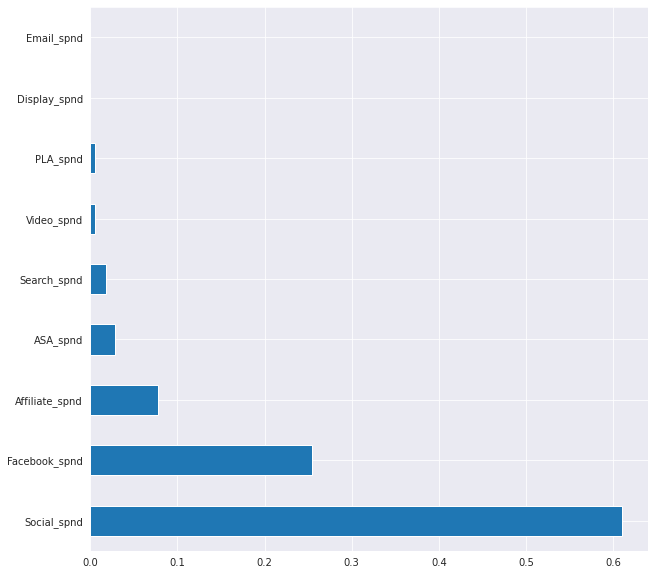

In [11]:
sp_cols = [col for col in df.columns if '_spnd' in col]
spend_df = df[sp_cols + ['sales']]

# Setting X and y variables
X = spend_df.loc[:, spend_df.columns != 'sales']
y = spend_df['sales']
# Building Random Forest model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Visualizing Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

In [ ]:
# extract control model parameters and predict base sales -> df['base_sales']
def extract_ctrl_model(fit_result, pos_vars=pos_vars, pn_vars=pn_vars, 
                       extract_param_list=False):
    ctrl_model = {}
    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
        ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    pos_vars, pn_vars = ctrl_model['pos_vars'], ctrl_model['pn_vars'] 
    X1, X2 = df[pos_vars], df[pn_vars]
    beta1, beta2 = np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2) + alpha
    return y_pred

base_sales_model = extract_ctrl_model(fit1_result, pos_vars=pos_vars, pn_vars=pn_vars)
base_sales = ctrl_model_predict(base_sales_model, df_ctrl)
df['base_sales'] = base_sales*sc_ctrl['sales']
# evaluate control model
print('mape: ', funcs.mean_absolute_percentage_error(df['sales'], df['base_sales']))

# np.savetxt("base_sales_pred.csv", df['base_sales'].values, delimiter=",")
# save_json(base_sales_model, 'ctrl_model.json')
# df['base_sales'] = pd.read_csv('base_sales_pred.csv', header=None).values

In [ ]:
mdip_cols = [col for col in df.columns if '_imp' in col]
mdip_cols

In [ ]:
# 2.2 Marketing Mix Model
mdip_cols = [col for col in df.columns if '_imp' in col]
mdip_cols

df_mmm, sc_mmm = funcs.mean_log1p_trandform(df, ['sales', 'base_sales'])
mu_mdip = df[mdip_cols].apply(np.mean, axis=0).values
mu_mdip[1] = 0.00001
max_lag = 8
num_media = len(mdip_cols)
# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df[mdip_cols].values), axis=0)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df),1)
model_data2 = {
    'N': len(df),
    'max_lag': max_lag, 
    'num_media': num_media,
    'X_media': X_media, 
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['sales'].values
}

model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // the vector of sales
  real y[N];
  // the maximum duration of lag effect, in weeks
  int<lower=1> max_lag;
  // the number of media channels
  int<lower=1> num_media;
  // matrix of media variables
  matrix[N+max_lag-1, num_media] X_media;
  // vector of media variables' mean
  real mu_mdip[num_media];
  // the number of other control variables
  int<lower=1> num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for media variables and base sales
  vector<lower=0>[num_media+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak;
}
transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  // matrix of media variables after adstock
  matrix[N, num_media] X_media_adstocked;
  // matrix of all predictors
  matrix[N, num_media+num_ctrl] X;
  
  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] <- pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect <- Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] <- log1p(cum_effect/mu_mdip[media]);
    }
  X <- append_col(X_media_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''

sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
fit2 = sm2.sampling(data=model_data2, iter=1000, chains=3)
fit2_result = fit2.extract()

In [ ]:
# extract mmm parameters
def extract_mmm(fit_result, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'], 
                extract_param_list=True):
    mmm = {}
    
    mmm['max_lag'] = max_lag
    mmm['media_vars'], mmm['ctrl_vars'] = media_vars, ctrl_vars
    mmm['decay'] = decay = fit_result['decay'].mean(axis=0).tolist()
    mmm['peak'] = peak = fit_result['peak'].mean(axis=0).tolist()
    mmm['beta'] = fit_result['beta'].mean(axis=0).tolist()
    mmm['tau'] = fit_result['tau'].mean()
    if extract_param_list:
        mmm['decay_list'] = fit_result['decay'].tolist()
        mmm['peak_list'] = fit_result['peak'].tolist()
        mmm['beta_list'] = fit_result['beta'].tolist()
        mmm['tau_list'] = fit_result['tau'].tolist()
    
    adstock_params = {}
    media_names = [col.replace('mdip_', '') for col in media_vars]
    for i in range(len(media_names)):
        adstock_params[media_names[i]] = {
            'L': max_lag,
            'P': peak[i],
            'D': decay[i]
        }
    mmm['adstock_params'] = adstock_params
    return mmm

mmm = extract_mmm(fit2, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'])
# save_json(mmm, 'mmm1.json')


# plot media coefficients' distributions
# red line: mean, green line: median
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_media[md] = np.array(betas)

f = plt.figure(figsize=(18,15))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)

In [ ]:
# Decompose sales to media channels' contribution
# Each media channel's contribution = total sales - sales upon removal the channel    

# decompose sales to media contribution
def mmm_decompose_contrib(mmm, df, original_sales=df['sales']):
    # adstock params
    adstock_params = mmm['adstock_params']
    # coefficients, intercept
    beta, tau = mmm['beta'], mmm['tau']
    # variables
    media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
    num_media, num_ctrl = len(media_vars), len(ctrl_vars)
    # X_media2: adstocked, mean-centered media variables + 1
    X_media2 = funcs.adstock_transform(df, media_vars, adstock_params)
    X_media2, sc_mmm2 = funcs.mean_center_transform(X_media2, media_vars)
    X_media2 = X_media2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = funcs.mean_center_transform(df[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = funcs.mean_center_transform(df, ['sales'])
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    # X2 <- media variables + ctrl variable
    X2 = pd.concat([X_media2, X_ctrl2], axis=1)

    # 1. compute each media/control factor: 
    # log-log model: log(sales) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: sales = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^tau
    factor_df = pd.DataFrame(columns=media_vars+ctrl_vars+['intercept'])
    for i in range(num_media):
        colname = media_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta[num_media+i]
    factor_df['intercept'] = np.exp(tau)

    # 2. calculate the product of all factors -> y_pred
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. calculate each media factor's contribution
    # media contribution = total volume – volume upon removal of the media factor
    mc_df = pd.DataFrame(columns=media_vars+['baseline'])
    for col in media_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df['baseline']
    mc_df['y_true2'] = factor_df['y_true2']

    # 4. scale contribution
    # predicted total media contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[media_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in media_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original sales
    mc_df['sales'] = original_sales
    for col in media_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['sales']/mc_df['y_true2']
    
    print('rmse (log-log model): ', 
         mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
    print('mape (multiplicative model): ', 
         funcs.mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

# calculate media contribution percentage
def calc_media_contrib_pct(mc_df, media_vars=mdip_cols, sales_col='sales', period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col]).mean()
    else:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col])[-period:].mean()
    for m in media_vars:
        s += mc_pct[m]
    for m in media_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2

In [ ]:
mmm['adstock_params']

In [ ]:
mc_df = mmm_decompose_contrib(mmm, df, original_sales=df['sales'])
adstock_params = mmm['adstock_params']
mc_pct, mc_pct2 = calc_media_contrib_pct(mc_df, period=52)
# mc_df.to_csv('mc_df1.csv', index=False)
# save_json(adstock_params, 'adstock_params1.json')
# pd.concat([
#     pd.DataFrame.from_dict(mc_pct, orient='index', columns=['mc_pct']),
#     pd.DataFrame.from_dict(mc_pct2, orient='index', columns=['mc_pct2'])
# ], axis=1).to_csv('mc_pct_df1.csv')


In [ ]:
adstock_params

In [ ]:
model_code3 = '''
functions {
  // the Hill function
  real Hill(real t, real ec, real slope) {
  return 1 / (1 + (t / ec)^(-slope));
  }
}

data {
  // the total number of observations
  int<lower=1> N;
  // y: vector of media contribution
  vector[N] y;
  // X: vector of adstocked media spending
  vector[N] X;
}

parameters {
  // residual variance
  real<lower=0> noise_var;
  // regression coefficient
  real<lower=0> beta_hill;
  // ec50 and slope for Hill function of the media
  real<lower=0,upper=1> ec;
  real<lower=0> slope;
}

transformed parameters {
  // a vector of the mean response
  vector[N] mu;
  for (i in 1:N) {
    mu[i] <- beta_hill * Hill(X[i], ec, slope);
  }
}

model {
  slope ~ gamma(3, 1);
  ec ~ beta(2, 2);
  beta_hill ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01); 
  y ~ normal(mu, sqrt(noise_var));
}
'''




In [ ]:
# train hill models for all media channels
#sm3 = pystan.StanModel(model_code=model_code3, verbose=True)
hill_models = {}
to_train = ['dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem']
to_train = ['ASA', 'Affiliate', 'Display', 'Email', 'PLA', 'Search', 'Social', 'Video']
for media in to_train:
    print('training for media: ', media)
    hill_model = funcs.train_hill_model(df, mc_df, adstock_params, media, sm3)
    print("trained for media: ", media)
    hill_models[media] = hill_model

# extract params by mean
hill_model_params_mean, hill_model_params_med = {}, {}
for md in list(hill_models.keys()):
    print("extracting " + md)
    hill_model = hill_models[md]
    params1 = funcs.extract_hill_model_params(hill_model, method='mean')
    params1['sc'] = hill_model['sc']
    hill_model_params_mean[md] = params1
#     params2 = extract_hill_model_params(hill_model, method='median')
#     params2['sc'] = hill_model['sc']
#     hill_model_params_med[md] = params2
# save_json(hill_model_params_med, 'hill_model_params_med.json')
# save_json(hill_model_params_mean, 'hill_model_params_mean.json')

# evaluate model params extracted by mean
for md in list(hill_models.keys()):
    print('evaluating media: ', md)
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    _ = funcs.evaluate_hill_model(hill_model, hill_model_params)
# evaluate model params extracted by median
# for md in list(hill_models.keys()):
#     print('evaluating media: ', md)
#     hill_model = hill_models[md]
#     hill_model_params = hill_model_params_med[md]
#     _ = evaluate_hill_model(hill_model, hill_model_params)



In [ ]:
ms_df.head(2)

In [ ]:
# Calculate overall ROAS and weekly ROAS
# - Overall ROAS = total contribution / total spending
# - Weekly ROAS = weekly contribution / weekly spending

# adstocked media spending
ms_df = pd.DataFrame()
for md in list(hill_models.keys()):
    #print("md: ",md)
    hill_model = hill_models[md]
    x = np.array(hill_model['data']['X']) * hill_model['sc']['x']
    ms_df[md+"_spnd"] = x
# ms_df.to_csv('ms_df1.csv', index=False)

roas_1y = funcs.calc_roas(mc_df, ms_df, period=52)
weekly_roas = funcs.calc_weekly_roas(mc_df, ms_df)
roas1y_df = pd.DataFrame(index=weekly_roas.columns.tolist())
roas1y_df['roas_mean'] = weekly_roas[-52:].apply(np.mean, axis=0)
roas1y_df['roas_median'] = weekly_roas[-52:].apply(np.median, axis=0)


# # plot weekly ROAS distribution
# # median: green line, mean: red line
# f = plt.figure(figsize=(18,12))
# for i in range(len(weekly_roas.columns)):
#     md = weekly_roas.columns[i]
#     ax = f.add_subplot(4,3,i+1)
#     x = weekly_roas[md]
#     mean_x = np.mean(x)
#     median_x = np.median(x)
#     ax = sns.distplot(x)
#     ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
#     ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
#     ax.set(xlabel=None)
#     ax.set_title(md)

# plot weekly ROAS distribution of past 1 year
# median: green line, mean: red line
f = plt.figure(figsize=(18,12))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:]
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)


# Calculate mROAS
# 1. Current spending level (cur_sp) is represented by mean or median of weekly spending.    
# Next spending level (next_sp) is increasing cur_sp by 1%.
# 2. Plug cur_sp and next_sp into the Hill function:    
# Current media contribution: cur_mc = Hill(cur_sp)    
# Next-level media contribution next_mc = Hill(next_sp)    
# 3. mROAS = (next_mc - cur_mc) / (0.01 * cur_sp)


# calc mROAS of recent 1 year
mroas_1y = {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    mroas_1y[md] = funcs.calc_mroas(hill_model, hill_model_params, period=52)

roas1y_df = pd.concat([
    roas1y_df[['roas_mean', 'roas_median']],
    pd.DataFrame.from_dict(mroas_1y, orient='index', columns=['mroas']),
    pd.DataFrame.from_dict(roas_1y, orient='index', columns=['roas_avg'])
], axis=1)
# roas1y_df.to_csv('roas1y_df1.csv')

roas1y_df
# **ROAS & mROAS**    
# 'roas_avg': overall ROAS = total contribution / total spending    
# 'roas_mean': mean of weekly ROAS    
# 'roas_median': median of weekly ROAS    
# 'mroas': mROAS calculated based on increasing current spending level by 1%   